# Toronto Bike Share - 2017 Operations Analysis

In [3]:
#Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
plt.rcParams['figure.facecolor'] = 'w'

In [7]:
#Import dataset
df = pd.read_csv('2017_Toronto_Bikeshare.csv')

### DATA DISCOVERY
- Getting to know and interact with the data

In [34]:
#Sample data
df.head();

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
784682,1600719,8/16/2017 13:45,8/16/2017 13:52,426.0,College Park South,Simcoe St / Queen St W,Member,NaN,NaN
350502,1121773,8/6/2017 20:08,8/6/2017 20:20,731.0,7030,Bay St / Wellesley St W,7056,Parliament St / Gerrard St,Member
1468642,2353019,2012-12-17 9:36,2012-12-17 9:44,467.0,Bloor St W / Manning Ave - SMART,St. George St / Bloor St W,Member,NaN,NaN
107007,839665,17/03/2017 22:48,17/03/2017 23:09,1265.0,7107,Cherry St / Distillery Ln,7044,Church St / Alexander St,Member
499844,1291109,7/6/2017 7:48,7/6/2017 8:14,1568.0,East Liberty St / Pirandello St,Bay St / College St (East Side),Member,NaN,NaN


In [45]:
# Sample 5 rows of dataframe
df.sample(5)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
75541,801772,24/02/2017 21:48,24/02/2017 23:14,5164.0,7169,Front St / Bay St (North Side),7101,Lower Sherbourne St / The Esplanade,Casual
808893,1627197,8/19/2017 20:34,8/19/2017 20:46,728.0,Queen St W / Portland St,Queen St W / Cowan Ave,Member,NaN,NaN
550219,1346230,7/13/2017 17:36,7/13/2017 17:51,873.0,Metro Hall Plaza,Church St / Wood St,Member,NaN,NaN
1251797,2106489,10/20/17 17:05:51,10/20/17 17:26:54,1263.0,Church St / Bloor St E,Dufferin St / Sylvan Av (Dufferin Grove Park),Member,NaN,NaN
594252,1393748,7/19/2017 19:59,7/19/2017 20:00,28.0,Lower Jarvis St / The Esplanade,Lower Jarvis St / The Esplanade,Casual,NaN,NaN


In [46]:
# Get more info about dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492370 entries, 0 to 1492369
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trip_id                1492370 non-null  object 
 1   trip_start_time        1492369 non-null  object 
 2   trip_stop_time         1492369 non-null  object 
 3   trip_duration_seconds  1492369 non-null  float64
 4   from_station_id        1492369 non-null  object 
 5   from_station_name      1492368 non-null  object 
 6   to_station_id          1492369 non-null  object 
 7   to_station_name        465476 non-null   object 
 8   user_type              465476 non-null   object 
dtypes: float64(1), object(8)
memory usage: 102.5+ MB


In [9]:
# CHECK NUMBER OF ROWS AND COLUMNS
df.shape

(1492370, 9)

In [28]:
# check the columns that make up the dataset
df.columns

Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'user_type'],
      dtype='object')

In [29]:
# check datatype of individual columns
df.dtypes  # All the columns except "trip_duration_seconds" are of object/string data type

trip_id                   object
trip_start_time           object
trip_stop_time            object
trip_duration_seconds    float64
from_station_id           object
from_station_name         object
to_station_id             object
to_station_name           object
user_type                 object
dtype: object

In [25]:
df.describe() # Describe basic statistics about the dataset. Only numeric feature(s) is(are) evaluated

,trip_duration_seconds
count,1.492369e+06
mean,1.017616e+03
std,9.772787e+03
min,0.000000e+00
25%,4.150000e+02
50%,6.540000e+02
75%,1.020000e+03
max,6.382030e+06


In [23]:
# Check for duplicates
print(df.duplicated().sum()); #...No duplicates (Means the primary key column - "trip_id", has no duplicates)
df[df.duplicated(['trip_id'])]

0


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type


In [47]:
#check for NaN 
df.isnull().sum()  #....to_station_name and user_type columns have 1026894 NaN records each. Other columns have have 
                   # 1 or 2 NaNs     

trip_id                        0
trip_start_time                1
trip_stop_time                 1
trip_duration_seconds          1
from_station_id                1
from_station_name              2
to_station_id                  1
to_station_name          1026894
user_type                1026894
dtype: int64

### DATA PRE-PROCESSING
We need to have our data ready for analysis in order to produce objective inference. We have to first pre-process the data by removing records with NaNs as well as those that are out of scope

In [48]:
#Drop Nan records for spicified columns
df.dropna(subset = ['trip_start_time','trip_stop_time','trip_duration_seconds','from_station_id','from_station_name','to_station_id'], inplace = True)

In [49]:
#QC Check
df.isnull().sum()

trip_id                        0
trip_start_time                0
trip_stop_time                 0
trip_duration_seconds          0
from_station_id                0
from_station_name              0
to_station_id                  0
to_station_name          1026892
user_type                1026892
dtype: int64

Notice that for columns --- to_station_name and user_type, there over 1 million NaNs out of about 1.5m columns.
A lot of valuable data/information is likely to be lost if we delete all NAN records for those 2 columns. Hence, we'd keep those 2 columns as they are for now.

#### Convert Date/Time Related Columns from Object Type to Datetime
To perform time related analysis on "trip_start_time" and "trip_stop_time" columns, we need them to be in datetime type

In [78]:
df.iloc[1251797]

trip_id                                                        2106489
trip_start_time                                    2017-10-20 17:05:51
trip_stop_time                                     2017-10-20 17:26:54
trip_duration_seconds                                             1263
from_station_id                                 Church St / Bloor St E
from_station_name        Dufferin St / Sylvan Av (Dufferin Grove Park)
to_station_id                                                   Member
to_station_name                                                    NaN
user_type                                                          NaN
Name: 1251797, dtype: object

In [72]:
# Convert from Object to Datatime data type

df['trip_start_time'] = pd.to_datetime(df['trip_start_time'], dayfirst = True) #----change from object type to datetime
df['trip_stop_time'] = pd.to_datetime(df['trip_stop_time'], dayfirst = True)  # ----change from object type to datetime

In [74]:
# Confirm conversion to Datetime data type

df.dtypes

trip_id                          object
trip_start_time          datetime64[ns]
trip_stop_time           datetime64[ns]
trip_duration_seconds           float64
from_station_id                  object
from_station_name                object
to_station_id                    object
to_station_name                  object
user_type                        object
dtype: object

#### Be Sure All Records are for Year 2017

In [79]:
df[df['trip_start_time'].dt.year != 2017].head() # Some records are outside the scope of the year 2017

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
1128964,1971685,2010-01-17,2010-01-17 00:14:00,849.0,Queen St W / James St,Taddle Creek Park,Member,NaN,NaN
1128965,1971686,2010-01-17,2010-01-17 00:00:00,26.0,Stewart St / Bathurst St - SMART,Stewart St / Bathurst St - SMART,Casual,NaN,NaN
1128966,1971687,2010-01-17,2010-01-17 00:22:00,1310.0,Hayter St / Laplante Ave,Queen St W / Portland St,Member,NaN,NaN
1128967,1971688,2010-01-17,2010-01-17 00:11:00,631.0,Beverly St / College St,Beverly St / Dundas St W,Member,NaN,NaN
1128968,1971689,2010-01-17,2010-01-17 00:20:00,1198.0,Thompson St / Broadview Ave - SMART,Thompson St / Broadview Ave - SMART,Member,NaN,NaN


In [80]:
print(df[df['trip_start_time'].dt.year != 2017].shape) # No of records out of range
print(df[df['trip_start_time'].dt.year == 2017].shape) # No of records in range

(160070, 9)
(1332298, 9)


In [81]:
#Delete Records outside 2017 since Analysis is based on 2017 Data

df_2017 = df[df['trip_start_time'].dt.year == 2017]

In [85]:
# Check all records are now for year 2017

print(df_2017[df_2017['trip_start_time'].dt.year !=2017].shape[0])
# df_2017[df_2017['trip_start_time'].dt.year !=2017]

0


#### Trip Start Time Should Always Be Earlier than Trip Stop TIme

In [88]:
#Delete records with start time greater than stop time (Stop time should be greater)

print(df_2017[df_2017['trip_start_time'] > df_2017['trip_stop_time']].shape[0])

df_2017 = df_2017[df_2017['trip_start_time'] < df_2017['trip_stop_time']] # Delete

333


In [89]:
# Confirm the above operation

df_2017[df_2017['trip_start_time'] > df_2017['trip_stop_time']].shape[0]

0

In [94]:
# The Date fields/columns look fine now with range starting from 01 Jan to 31 Dec., 2017

print(df_2017['trip_start_time'].min())
print(df_2017['trip_start_time'].max())

df_2017 

2017-01-01 00:00:00
2017-12-31 23:49:41


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
0,712382,2017-01-01 00:00:00,2017-01-01 00:03:00,223.0,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member
1,712383,2017-01-01 00:00:00,2017-01-01 00:05:00,279.0,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member
2,712384,2017-01-01 00:05:00,2017-01-01 00:29:00,1394.0,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member
3,712385,2017-01-01 00:07:00,2017-01-01 00:21:00,826.0,7077,College Park South,7010,King St W / Spadina Ave,Member
4,712386,2017-01-01 00:08:00,2017-01-01 00:12:00,279.0,7079,McGill St / Church St,7047,University Ave / Gerrard St W,Member
...,...,...,...,...,...,...,...,...,...
1492363,2383641,2017-12-31 23:42:06,2017-12-31 23:58:24,978.0,Elizabeth St / Edward St (Bus Terminal),Roxton Rd / College St,Member,NaN,NaN
1492364,2383642,2017-12-31 23:46:27,2017-12-31 23:46:53,26.0,Bloor St / Brunswick Ave,Bloor St / Brunswick Ave,Casual,NaN,NaN
1492366,2383644,2017-12-31 23:47:40,2017-12-31 23:57:49,609.0,Kendal Ave / Spadina Rd,Augusta Ave / Denison Sq,Member,NaN,NaN
1492367,2383645,2017-12-31 23:49:08,2017-12-31 23:49:34,26.0,Phoebe St / Spadina Ave,Phoebe St / Spadina Ave,Member,NaN,NaN


### Generated / Derived Columns
We need to generate more columns from the existing ones to allow us expand the scope of the data analysis

In [95]:
df_2017.keys()

Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'user_type'],
      dtype='object')

#### Derive 'Actual Duration' and 'Overage' Columns

* Assumption - (trip start and stop times are actual ride times that trips lasted while trip duration is the booked time for the trips)
* Actual duration = trip_stop_time - trip_start_time


In [245]:
# Let's rename 'trip_duration_seconds' column to 'booked_duration_seconds'. This is to reflect our assumption

df_2017.rename(columns={'trip_duration_seconds': 'booked_duration_seconds'}, inplace=True)

In [256]:
# Let's use the below function to derive 2 more columns crucial to our data analysis
# 'Actual Duration' and 'Overage' Columns

def actual_duration(dataframe):
    ''' 
    This funtion takes a dataframe containing 2 datetime columns and outputs a dataframe with an added column,
    'actual_duration' which evaluates the time difference between the initial 2 datetime columns, and anther 
    another column, 'Overages' which evaluates the overage time for each trip
    '''
    
    # Difference between stop and start time express which ranges from days to seconds
    dataframe['actual_Timedelta']=dataframe.trip_stop_time - dataframe.trip_start_time
    
    # Raise Exception if required date time columns are absent
    if ("trip_stop_time" or "trip_start_time") not in dataframe.columns.tolist():
        raise KeyError('necessary datetime columns missing')
    
    Bool=dataframe[['trip_stop_time','trip_start_time']].dtypes=='datetime64[ns]'
     
    # Raise exception if data types of trip_stop_time and trip_start_time are not datetime64[ns]
    if not Bool.all():
        raise ValueError('column is not datetime type, can not perform operation')
        
    
    # Extract the days part of each record
    dataframe['actual_days']=dataframe['actual_Timedelta'].dt.days

    # Extract the seconds part of each record
    dataframe['actual_seconds']=dataframe['actual_Timedelta'].dt.seconds

    # Sum the parts to get total of each record in seconds
    dataframe['actual_duration']=(dataframe['actual_days']*24*60*60)+dataframe['actual_seconds']

    dataframe.drop(['actual_Timedelta','actual_days','actual_seconds'], axis=1, inplace=True)

    # Determine Overage for each trip
    #overage = Actual_duration - Booked_duration
    dataframe['overage']=dataframe['actual_duration']-dataframe['booked_duration_seconds']
        
        
    
    # Output the dataframe with the added columns as actual duration is seconds
    return(dataframe)
    
    

In [249]:
# Call the above function and pass it to the variable name, df_2017

df_2017 = actual_duration(df_2017)

In [255]:
print(df_2017[['actual_duration','overage']].head())
df_2017.head(3)

   actual_duration  overage
0              180    -43.0
1              300     21.0
2             1440     46.0
3              840     14.0
4              240    -39.0


,trip_id,trip_start_time,trip_stop_time,booked_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,actual_duration,overage
0,712382,2017-01-01 00:00:00,2017-01-01 00:03:00,223.0,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member,180,-43.0
1,712383,2017-01-01 00:00:00,2017-01-01 00:05:00,279.0,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member,300,21.0
2,712384,2017-01-01 00:05:00,2017-01-01 00:29:00,1394.0,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member,1440,46.0


#### Derive Overage Charges
Let's derive the column for overage charges

Toronto Bike Share Overage Price Model as given below is used to calculate overage charges

Overage price model
- Types of overage:       Charge per model
- Type 1  0-30 minutes ---- 4 * 1
- Type 2  31-60 minutes --- 4 * 2
- Type 3  61-90 minutes --- 4 * 3
- Type 4  91-120 minutes -- 4 * 4
- Type 5  120+ minutes ---- 4 * 5

In [259]:
# Determine Overage Charges


# Create a function to generate charges (Bin the charges)

def overage_charge(overage):
    '''
    This function creates different buckets for overage ranges and applies charges based on stated 
    price model
    
    '''
    overage/=60 # convert time overage from seconds to minutes
    
    if overage > 0 and overage <= 30: # charge $4 if time overage is between 0 and 30 mins
        return(int(4))
    elif overage > 30 and overage <= 60: # charge $8 if time overage is between 30 and 60 mins
        return(int(4*2))
    elif overage > 60 and overage <= 90: # charge $12 if time overage is between 60 and 90 mins
        return(int(4*3))
    elif overage > 90 and overage <= 120: # charge $16 if time overage is between 90 and 120 mins
        return(int(4*4))
    elif overage > 120:                   # charge $20 if time overage is above 120 mins
        return(int(4*5))
    else:
        return(int(0))

In [263]:
#Apply overage function on overage column to derive overage charge

df_2017['overage_charges'] = df_2017['overage'].apply(overage_charge)

In [265]:
# Let's check to confirm the 3 new derived columns created
# -ve overage charge means actual trip time was less than booked time 

df_2017[['actual_duration','overage','overage_charges']].head() 

,actual_duration,overage,overage_charges
0,180,-43.0,0
1,300,21.0,4
2,1440,46.0,4
3,840,14.0,4
4,240,-39.0,0


#### Derive More Columns from 'trip_start_time' column

We will have to derive extra date related columns that will allow us answer more questions in our data analysis

In [410]:
# Extracting date related columns from trip_start_time

def date_columns(dataframe):
    '''
    This function takes in a dataframe with a datetime column and extracts other date related columns such as
    weekday, day_of_month, month_of_year and quarter.
    '''
    
    # Extract weekday
    dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    dataframe['trip_start_weekday'] = dataframe['trip_start_time'].dt.weekday.map(dayOfWeek)
    
    # Extract days of the month
    dataframe['trip_start_DayOfMonth']=dataframe['trip_start_time'].dt.day
    
    # Extract months of the year
    MonthofYear = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 
                   7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
    dataframe['trip_start_time_month'] = dataframe['trip_start_time'].dt.month.map(MonthofYear)
    
    # Extract Day of year
    dataframe['Day_of_Year']=dataframe['trip_start_time'].dt.dayofyear
    
    # Extract quarters of the year
    QuarterofYear = {1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'}
    dataframe['Quarter'] = dataframe['trip_start_time'].dt.quarter.map(QuarterofYear)
    
    # return dataframe with added columns
    return(dataframe)
    

In [411]:
# Let's call the function and assign it a variable - df_2017

df_2017=date_columns(df_2017)

In [328]:
# Let's convert actual_duration from seconds to minutes for ease of analysis

df_2017['actual_duration_minutes']=df_2017['actual_duration']/60

df_2017['actual_duration_minutes']=df_2017['actual_duration_minutes'].round(2)

Remember we initially started with only 9 columns. 
Let's see how many more columns we now have and what they are;


In [412]:
print(df_2017.shape[1]) # Current number of columns

print(len(df_2017.columns.tolist()[9:])) # Number of derived columns

print(df_2017.columns.tolist()[9:]) # Print the new derived columns

18
9
['actual_duration', 'overage', 'overage_charges', 'trip_start_weekday', 'trip_start_DayOfMonth', 'trip_start_time_month', 'Quarter', 'actual_duration_minutes', 'Day_of_Year']


In [413]:
# show records of the derived columns

df_2017[df_2017.columns.tolist()[9:]].head()

,actual_duration,overage,overage_charges,trip_start_weekday,trip_start_DayOfMonth,trip_start_time_month,Quarter,actual_duration_minutes,Day_of_Year
0,180,-43.0,0,Sunday,1,January,Q1,3.0,1
1,300,21.0,4,Sunday,1,January,Q1,5.0,1
2,1440,46.0,4,Sunday,1,January,Q1,24.0,1
3,840,14.0,4,Sunday,1,January,Q1,14.0,1
4,240,-39.0,0,Sunday,1,January,Q1,4.0,1


In [330]:
df_2017.head(3) # Let's take a view

,trip_id,trip_start_time,trip_stop_time,booked_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,actual_duration,overage,overage_charges,trip_start_weekday,trip_start_DayOfMonth,trip_start_time_month,Quarter,actual_duration_minutes
0,712382,2017-01-01 00:00:00,2017-01-01 00:03:00,223.0,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member,180,-43.0,0,Sunday,1,January,Q1,3.0
1,712383,2017-01-01 00:00:00,2017-01-01 00:05:00,279.0,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member,300,21.0,4,Sunday,1,January,Q1,5.0
2,712384,2017-01-01 00:05:00,2017-01-01 00:29:00,1394.0,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member,1440,46.0,4,Sunday,1,January,Q1,24.0


Our data is now ready for Data Analysis.

Now let's save it as csv file to be used for our analysis subsequently

In [331]:
# df_2017.to_csv('./prep_data', index=False)

## DATA ANALYSIS AND VIZ
Let's start answering business questions using data analysis

In [6]:
# Load preprocessed data

df_2 = pd.read_csv('./prep_data', parse_dates=['trip_start_time','trip_stop_time'])

In [7]:
df_preprocessed = df_2.copy()

### Average Trip Time(minutes) and Average Count of Trips Per Day

In [191]:
# Get Average Trip time in minutes per day

av_trip_time = df_2.resample('D', on='trip_start_time').mean().drop(columns=['trip_id', 'booked_duration_seconds',
       'actual_duration', 'overage', 'overage_charges',
       'trip_start_DayOfMonth'])#.plot(df_2['trip_start_time'], df_2['actual_duration_minutes'], kind='scatter')

In [192]:
av_trip_time.sort_values(by='actual_duration_minutes', ascending=False).round(2)#.head()

,actual_duration_minutes
trip_start_time,
2017-01-07,995.86
2017-07-08,580.39
2017-08-07,480.57
2017-09-09,427.23
2017-07-07,419.78
...,...
2017-12-05,NaN
2017-12-06,NaN
2017-12-10,NaN


In [194]:
av_trip_time.isna().sum() # How many rows of NANs -- 54

actual_duration_minutes    54
dtype: int64

In [195]:
av_trip_time=av_trip_time.dropna()  # 311 rows retained, 54 rows dropped

In [214]:
# Average Daily Trip Time in Minutes is 42 mins
print(av_trip_time.mean())
print(av_trip_time.max())
print(av_trip_time.min())

actual_duration_minutes    41.860875
dtype: float64
actual_duration_minutes    995.855579
dtype: float64
actual_duration_minutes    9.035808
dtype: float64


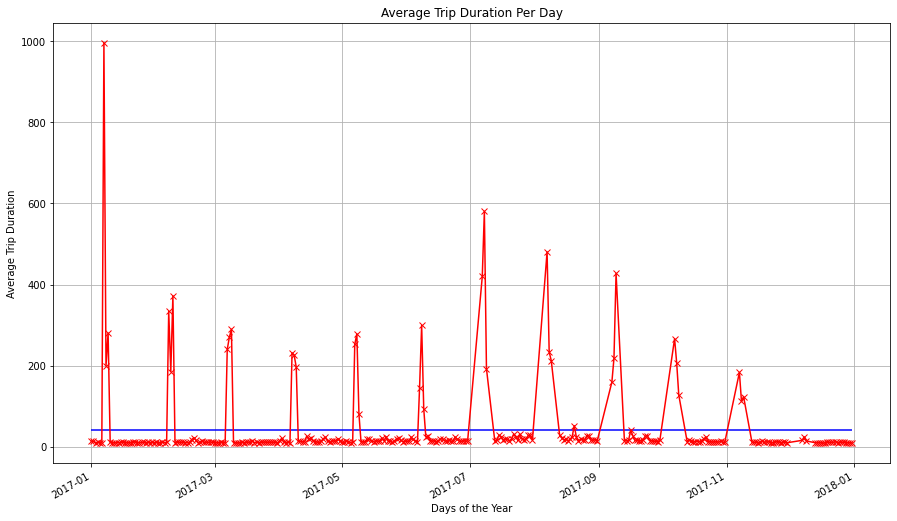

In [213]:
# Line Plot

av_trip_time['actual_duration_minutes'].plot(kind='line', figsize=(15,9), marker='x', color='red')
plt.hlines(y=av_trip_time.mean(),xmin='2017-01-01',xmax='2017-12-31', color='b')
plt.title('Average Trip Duration Per Day')
plt.ylabel('Average Trip Duration')
plt.xlabel('Days of the Year')
plt.grid()

* From the above plot, we see prominent outliers in January and July for average daily trip duration
* Average daily trip duration for 2017 is 42 minutes
* Most trips are below 20 minutes
* Max and min trip durations are 996 and 9 minutes respectively


In [180]:
# Get Daily Trip count per day

daily_trip_count=df_2.resample('D', on=
                               'trip_start_time').count()[[
                                'trip_id']].rename(columns={'trip_id':'Daily_trip_count'})

Text(0.5, 0, 'Days of the Year')

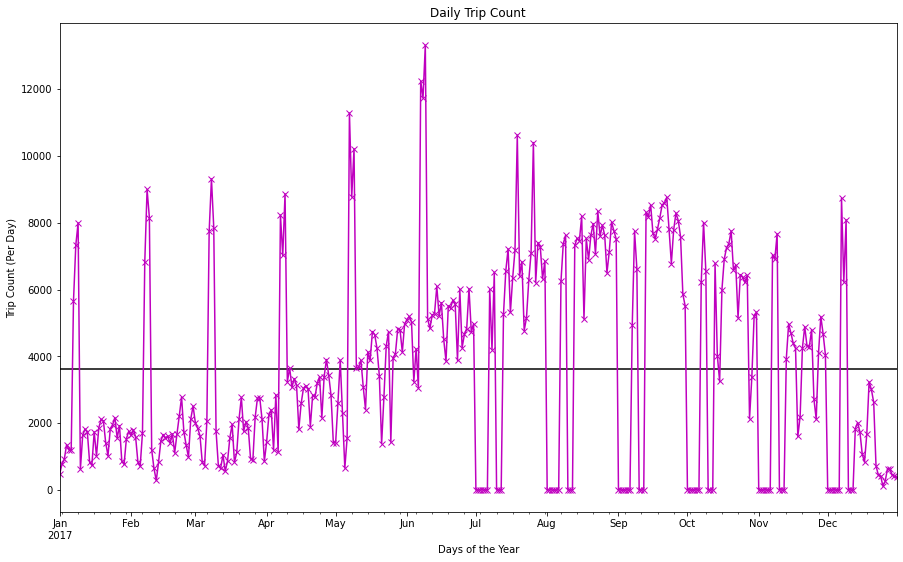

In [212]:
# Line Plot

daily_trip_count['Daily_trip_count'].plot(kind='line', figsize=(15,9), marker='x', color='m')
plt.hlines(y=daily_trip_count.mean(),xmin='2017-01-01',xmax='2017-12-31', color='k')
plt.title('Daily Trip Count')
plt.ylabel('Trip Count (Per Day)')
plt.xlabel('Days of the Year')

In [216]:
# Average Daily Trip Time in Minutes is 42 mins
print(daily_trip_count.mean())
print(daily_trip_count.max())
print(daily_trip_count.min())

Daily_trip_count    3613.413699
dtype: float64
Daily_trip_count    13318
dtype: int64
Daily_trip_count    0
dtype: int64


* We see a steady rise in daily trip count from April to Septempter (predominantly summer)
* Notable outliers in the month of June with regards to daily trip count
* Average daily trip count for 2017 is 3

In [65]:
st=av_tr['trip_start_time'].dt.strftime('%Y-%m-%d')

In [55]:
pd.Timestamp(av_tr['trip_start_time'])

TypeError: Cannot convert input [0     2017-01-01
1     2017-01-02
2     2017-01-03
3     2017-01-04
4     2017-01-05
         ...    
360   2017-12-27
361   2017-12-28
362   2017-12-29
363   2017-12-30
364   2017-12-31
Name: trip_start_time, Length: 365, dtype: datetime64[ns]] of type <class 'pandas.core.series.Series'> to Timestamp

In [54]:
av_tr.plot(av_tr['trip_start_time'].astype(str), av_tr['actual_duration_minutes'])

KeyError: "None of [Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',\n       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',\n       ...\n       '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',\n       '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', '2017-12-31'],\n      dtype='object', length=365)] are in the [columns]"

In [ ]:
df_2017.groupby()

In [46]:
#df_2017.groupby('Quarter')['actual_duration_minutes'].mean().round(2).sort_values(ascending=False)#.plot.bar()

In [101]:
#DATA ANALYSIS
#Most popular weekdays by Quarter
data.groupby(['trip_start_time_weekday','trip_start_time_month'])['trip_duration_seconds'].count().unstack().sort_values(by = 'February', ascending = False)

trip_start_time_month,April,August,December,February,January,July,June,March,May,November,October,September
trip_start_time_weekday,,,,,,,,,,,,
Wednesday,12335,31925,5485,14505,7028,21032,30059,16721,22002,20594,13631,24914
Thursday,10275,20247,14021,14299,6693,17878,32345,15419,12058,20396,13586,29315
Tuesday,10136,29925,3499,12489,6254,14285,18623,13832,25142,22092,18683,16450
Friday,17645,15456,9142,6155,6931,26809,32979,8053,12729,9044,20964,30900
Monday,12066,28899,1795,5787,13886,19489,19638,7408,21902,12282,22919,15607
Saturday,15901,14528,10030,4229,8791,23474,20689,3322,12150,4330,18958,27633
Sunday,18314,21452,1641,3653,10344,23316,16195,3388,19911,4312,21371,14306


In [415]:
data.groupby(['trip_start_time_weekday','Quarter'])['trip_duration_seconds'].count().reset_index().unstack().sort_values(by = 'Q1', ascending = False)

NameError: name 'data' is not defined

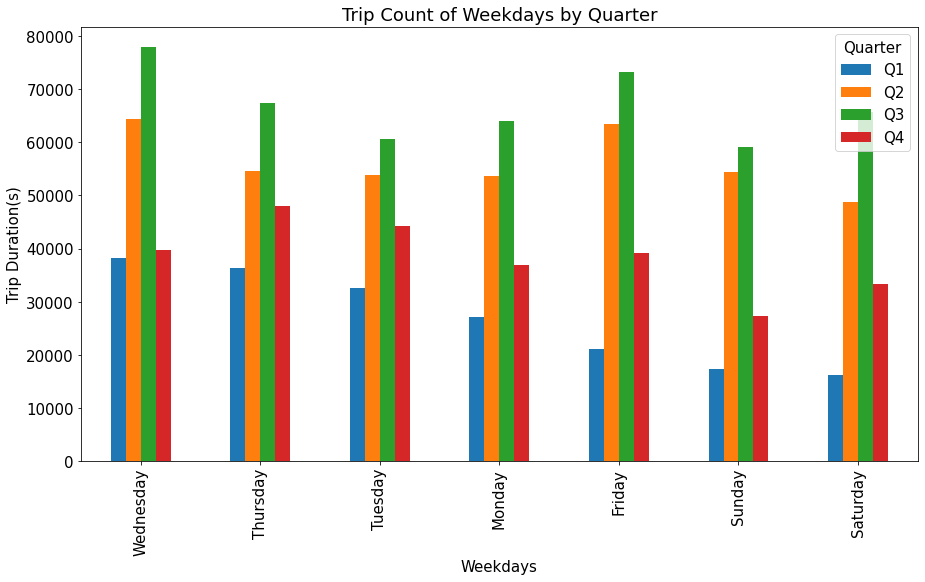

In [103]:
#Data Visualization
data.pivot_table(values ='trip_duration_seconds', columns = ['Quarter'], index = 'trip_start_time_weekday', aggfunc = 'count').sort_values(by ='Q1', ascending = False).plot.bar()
plt.title('Trip Count of Weekdays by Quarter')
plt.ylabel('Trip Duration(s)')
plt.xlabel('Weekdays')
from pylab import *
rcParams['figure.figsize'] = 15,8
plt.rcParams.update({'font.size': 15})

In [104]:
#Average ride time per day of the week, month --(startday_of_month,trip_start_time_weekday )
#Per Day of the Week
data.groupby(['trip_start_time_weekday'])[['booked_duration']].mean().sort_values(by = 'booked_duration', ascending = False).round(2)  #.head(4)

,booked_duration
trip_start_time_weekday,
Saturday,6286.36
Sunday,4468.26
Thursday,3732.22
Monday,3574.47
Tuesday,3196.21
Friday,2999.49
Wednesday,2976.41


In [105]:
#Average ride time per day of the week, month --(startday_of_month,trip_start_time_weekday )
#Per Day of the Month
data.groupby(['startday_of_month'])[['booked_duration']].mean().sort_values(by = 'booked_duration', ascending = False).round(2).head(4)

,booked_duration
startday_of_month,
7,16924.69
8,13866.09
9,11449.20
16,1195.56


Text(0.5, 0, 'Weekdays')

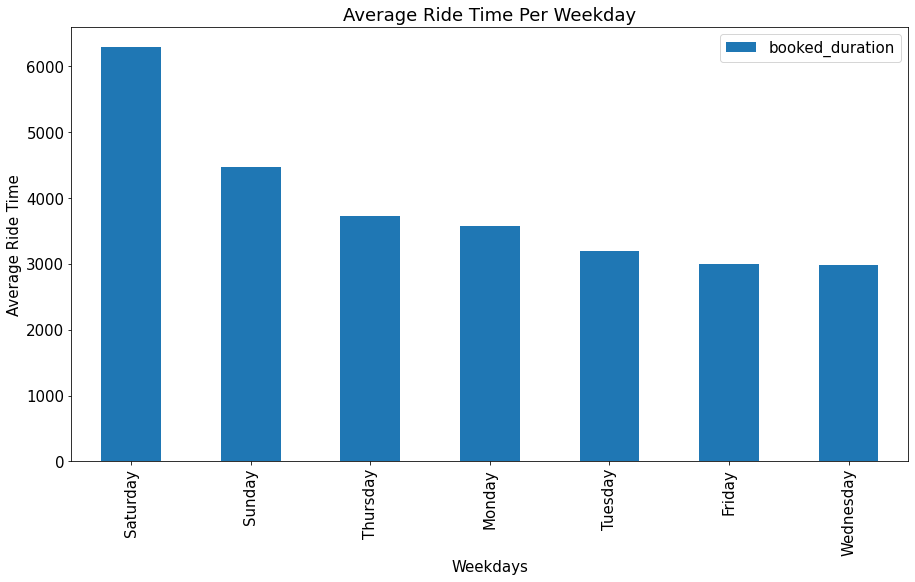

In [106]:
#Data Visualization
data.groupby(['trip_start_time_weekday'])[['booked_duration']].mean().sort_values(by = 'booked_duration', ascending = False).round(2).plot.bar()
plt.title('Average Ride Time Per Weekday')
plt.ylabel('Average Ride Time')
plt.xlabel('Weekdays')

In [0]:
#Average daily trips per month
data.groupby('trip_start_time_month').count()    #['trip_duration_seconds'].sum().mean()

In [107]:
#Get count of trips for each month, then divide by number of days per month for the average daily trips per month
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']
trips_per_months = []
for month in Months:
  if month == Months[1]:
    trips_per_months.append(data[data['trip_start_time_month'] == month].shape[0] /28)
  elif month in ['April','June','November']:
    trips_per_months.append(data[data['trip_start_time_month'] == month].shape[0] /30)
  else:
    trips_per_months.append(data[data['trip_start_time_month'] == month].shape[0] /31)
for month, average in zip(Months, trips_per_months):
  print(f'Average daily trips for {month} is {average}')

Average daily trips for January is 1933.1290322580646
Average daily trips for February is 2182.75
Average daily trips for March is 2198.1612903225805
Average daily trips for April is 3222.4
Average daily trips for May is 4061.0967741935483
Average daily trips for June is 5684.266666666666
Average daily trips for July is 4718.806451612903
Average daily trips for August is 5239.741935483871
Average daily trips for September is 5133.064516129032
Average daily trips for October is 4197.1612903225805
Average daily trips for November is 3101.6666666666665
Average daily trips for December is 1471.3870967741937


In [109]:
#Popular start stations 
data['from_station_name'].value_counts()

Union Station                                 23139
Simcoe St / Wellington St W                   19255
York St / Queens Quay W                       18184
King St W / Spadina Ave                       17032
Queen St W / Portland St                      15583
                                              ...  
Dufferin Gate - SMART                           203
Victoria Park Subway Station - SMART            143
Summerhill Ave / MacLennan Ave - SMART          131
Dundas St W / Roncesvalles Green P - SMART      108
Fringe Next Stage - 7219                         29
Name: from_station_name, Length: 292, dtype: int64

In [110]:
#Popular start stations 
data['to_station_name'].value_counts()

Union Station                              9989
Simcoe St / Wellington St W                8068
Dundas St / Yonge St                       7443
King St W / Spadina Ave                    7395
Princess St / Adelaide St                  6685
                                           ... 
Danforth Ave / Barrington Ave               189
Lansdowne Ave / Whytock Ave                 176
Stephenson Ave / Main St                    164
Danforth Ave / Westlake Ave                 126
Woodbine Subway Green P (Cedarvale Ave)     122
Name: to_station_name, Length: 200, dtype: int64

In [111]:
#Total Overage trips
data[data['overage'] > 0].shape[0]

554424

In [112]:
#Money made from overage
data['overage_charges'].sum()

2240032

In [113]:
#show by type and member/non member (Note that User_type column has a lot of NaN values as such money made for such records cannot be directly calculated)
data.groupby('user_type')['overage_charges'].sum()

user_type
Casual    153348
Member    762408
Name: overage_charges, dtype: int64

In [114]:
#By Type
data.groupby(['overage_charges'])['overage_charges'].sum()

overage_charges
0           0
4     2212112
20      27920
Name: overage_charges, dtype: int64

#Types of overage: 
Type 1  0-30 minutes  --> 2212112

Type 2  31-60 minutes --> 0.00

Type 3  61-90 minutes --> 0.00

Type 4  91-120 minutes -> 0.00

Type 5 120+ minutes ----> 27920

In [2]:
import numpy as np

In [426]:
df_17.dtypes

trip_id                      int64
trip_start_time             object
trip_stop_time              object
booked_duration_seconds    float64
from_station_id             object
from_station_name           object
to_station_id               object
to_station_name             object
user_type                   object
actual_duration              int64
overage                    float64
overage_charges              int64
trip_start_weekday          object
trip_start_DayOfMonth        int64
trip_start_time_month       object
Quarter                     object
actual_duration_minutes    float64
dtype: object

In [1]:
d1.dtypes

NameError: name 'd1' is not defined

In [17]:
d1.resample('D', on='trip_start_time').count()

,trip_id,trip_start_time,trip_stop_time,booked_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,actual_duration,overage,overage_charges,trip_start_weekday,trip_start_DayOfMonth,trip_start_time_month,Quarter,actual_duration_minutes
trip_start_time,,,,,,,,,,,,,,,,,
2017-01-01,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487,487
2017-01-02,775,775,775,775,775,775,775,775,775,775,775,775,775,775,775,775,775
2017-01-03,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918
2017-01-04,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359,1359
2017-01-05,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,641,641,641,641,641,641,641,0,0,641,641,641,641,641,641,641,641
2017-12-28,640,640,640,640,640,640,640,0,0,640,640,640,640,640,640,640,640
2017-12-29,446,446,446,446,446,446,446,0,0,446,446,446,446,446,446,446,446


In [13]:
d1[d1['trip_start_time_month'] =='February'].shape[0]

61117